In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from scipy.stats import vonmises
from scipy.stats import norm, uniform

Alternated version of the network class to enable automated plotting

In [201]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):

    def __init__(self, width, depth):
        
        super(NeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        
        if depth == 4:
            
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(7, width),
                nn.ReLU(),
                nn.Linear(width, width),
                nn.ReLU(),
                nn.Linear(width, width),
                nn.ReLU(),
                nn.Linear(width, width),
                nn.ReLU(),
                nn.Linear(width, 1),
                nn.Sigmoid())
            
        elif depth == 3:
            
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(7, width),
                nn.ReLU(),
                nn.Linear(width, width),
                nn.ReLU(),
                nn.Linear(width, width),
                nn.ReLU(),
                nn.Linear(width, 1),
                nn.Sigmoid())
        else: 
            
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(7, width),
                nn.ReLU(),
                nn.Linear(width, width),
                nn.ReLU(),
                nn.Linear(width, 1),
                nn.Sigmoid())

    def forward(self, x):
        
        x = self.flatten(x)
        output = self.linear_relu_stack(x)
        
        return output

def get_model(width, depth):

    model = NeuralNetwork(width, depth).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()

    return model, optimizer, loss_fn

Using cpu device


Evaluation of the networks: 

- Training errors 
- Interpolation performance
- Extended ranges errors 


In [27]:
X_train = np.load(f'Thesis/code/data/training/in_{5}_{20}_{20}.npz')['arr_0']
y_train = np.load(f'Thesis/code/data/training/ts_{5}_{20}_{20}.npz')['arr_0']

In [28]:
# Training error

plt.rcParams["figure.figsize"] = (12,7.5)
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True


mode = 'training'
targets = y_train 
inputs = X_train

# -----------------------------------------------------------------------------------------------------------------

networks = [[100, 75, 50, 25], [71, 54, 36, 18], [59, 44, 30, 15]]
batch_sizes = [125, 250, 500]
folds = 4

n = len(targets)

all_errors = []
all_models = []
all_b_s = [] 

for b_s in tqdm(batch_sizes):
        
    for d, n_w in enumerate(networks):
        
        errors = []
        
        for w in n_w:
        
            tag = 'relu'+ (d+2) * f'_{w}'
            e = 0 
            
            for f in range(folds):
                
                model, optimizer, loss_fn = get_model(w, d+2)
                model.load_state_dict(torch.load(f'Thesis/code/models/{tag}_models/{tag}_batch_size_{b_s}_fold_{f+1}.pt', map_location=torch.device('cpu')))
                
                with torch.no_grad():
                    
                    y_pred = model(torch.Tensor(inputs)).detach().numpy().ravel()
                
                e += np.sum(np.abs(y_pred - targets))
            
            errors.append(e / (n * folds))
        all_errors.append((n_w , errors))
        
        x = [100, 75, 50, 25]
        plt.scatter(x, errors, label=f'depth={d+2}', marker='o')
        
        if d > 0:
            for i, txt in enumerate(n_w):
                plt.annotate(txt, (x[i], errors[i]), fontsize=15)
    
    plt.xticks([100, 75, 50, 25])
    plt.yticks(np.linspace(0.004, 0.02, 5))
    plt.tick_params(labelsize=20, pad=15)
    plt.grid(alpha=0.3)
    plt.title(f'Batch Size = {b_s}', fontsize=20)
    plt.ylabel('\n L1-Loss', fontsize=20, linespacing=3.5)
    if b_s==500:
        plt.xlabel('Hidden Layer Size of Reference Networks (blue)', fontsize=20)
    plt.legend(fontsize=20)
    plt.savefig(f'plots/{mode}_summary_{b_s}.png', bbox_inches='tight') 
    plt.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:02<00:00, 20.90s/it]


In [232]:
# Interpolation error

X_data = []
y_data = []

X_r = np.load(f'Thesis/code/data/training/in_5_20_20.npz')['arr_0']
y_r = np.load(f'Thesis/code/data/training/ts_5_20_20.npz')['arr_0']

X_data.append(X_r)
y_data.append(y_r)


for i in range(5):

    X_r = np.load(f'Thesis/code/data/testing/in_full_model_left_{i+1}.npz')['arr_0']
    y_r = np.load(f'Thesis/code/data/testing/ts_full_model_left_{i+1}.npz')['arr_0']
    
    X_data.append(X_r)
    y_data.append(y_r)

In [233]:
plt.rcParams["figure.figsize"] = (12,7.5)
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

component = 'full_model' # change here
networks = [[100, 75, 50, 25], [71, 54, 36, 18], [59, 44, 30, 15]]
batch_sizes = [125, 250, 500]
folds = 4

for b_s in tqdm(batch_sizes):
    
    fig, ax = plt.subplots(1, 3, figsize=(70,20),subplot_kw=dict(projection='3d'))
    fig.tight_layout()
    fig.suptitle(r'$\beta_{H_s}$, $\kappa_v$, $\kappa_h$, $\tau$, $\sigma_{H_p}$, Training Batch Size = ' + f'{b_s}',
                 y = 1, fontsize=60) # change here
    
    for d, n_w in enumerate(networks):
        
        x_values = []
        y_values = []
        errors = []
        
        for w in n_w:
        
            tag = 'relu'+ (d+2) * f'_{w}'
            
            for i in range(0, len(X_data)):
                
                e = 0 

                for f in range(folds):
                
                    model, optimizer, loss_fn = get_model(w, d+2)
                    model.load_state_dict(torch.load(f'Thesis/code/models/{tag}_models/{tag}_batch_size_{b_s}_fold_{f+1}.pt', map_location=torch.device('cpu')))
                
                    with torch.no_grad():
                    
                        y_pred_r = model(torch.Tensor(X_data[i])).detach().numpy().ravel()

                    
                    e += np.sum(np.abs(y_pred_r - y_data[i])) / len(y_data[i]) 
                    
                errors.append(e / folds)
                x_values.append(w)
                y_values.append(1-0.2*i)

                
        ax[d].plot_trisurf(y_values, x_values, errors, vmin=0.004, vmax=0.024, cmap='summer', edgecolor='none')
        ax[d].view_init(20, 70)
        ax[d].tick_params(labelsize=40, pad=40)
        ax[d].set_xlabel('\n Training-Testing Data Similarity', fontsize=50, linespacing=5.5)        
        ax[d].set_xticks(y_values)
        ax[d].set_ylabel('\n Hidden Layer Size', fontsize=50, linespacing=5.5)
        ax[d].set_yticks(n_w)
        ax[d].set_zticks(np.linspace(0.004, 0.024, 6))
        ax[d].set_zlabel('\n L1-Loss', fontsize=50, linespacing=7.5)
        ax[d].set_title(f'Depth = {d+2}', y=1, fontsize=50)
        
    fig.savefig(f'plots/training_testing_convergence_{component}_left_{b_s}.png')
    plt.close(fig)
    
print('Plots generated and saved!')

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:59<00:00, 119.68s/it]

Plots generated and saved!


In [226]:
X = np.load(f'Thesis/code/data/testing/in_tau_distribution.npz')['arr_0']
y = np.load(f'Thesis/code/data/testing/ts_tau_distribution.npz')['arr_0']

819200


In [229]:
# Extended ranges error

plt.rcParams["figure.figsize"] = (12,7.5)
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

component = 'tau' # change here
networks = [[100, 75, 50, 25], [71, 54, 36, 18], [59, 44, 30, 15]]
batch_sizes = [125, 250, 500]
folds = 4

n = len(X)
x_values = np.unique(X[:,3]) # change here

for b_s in tqdm(batch_sizes):

    for d, n_w in enumerate(networks):
        
        for w in n_w:
        
            tag = 'relu'+ (d+2) * f'_{w}'
                  
            errors = np.zeros(8)
                
            for f in range(folds):
                
                model, optimizer, loss_fn = get_model(w, d+2)
                model.load_state_dict(torch.load(f'Thesis/code/models/{tag}_models/{tag}_batch_size_{b_s}_fold_{f+1}.pt', map_location=torch.device('cpu')))
                    
                    
                for i in range(0, n, 102400):
                        
                    with torch.no_grad():
                    
                        y_pred = model(torch.Tensor(X)).detach().numpy().ravel()
                        
                    errors[int(i / 102400)] += np.sum(np.abs(y[i:i + 102400] - y_pred[i:i + 102400])) / 102400
                    
            errors = errors / folds
                
            
            plt.scatter(x_values, errors, label=f'size={w}', marker='_', s=40)

        plt.axvspan(0.79, 1, facecolor='grey', alpha=0.05)
        plt.annotate('Training Range', xy=(0.643 , 0.9), xycoords='axes fraction', fontsize=15)
        plt.tick_params(labelsize=20, pad=15)
        plt.xlabel(r'$\tau}$', fontsize=20) 
        plt.ylabel('L1-Loss', fontsize=20)
        plt.yticks(np.linspace(0, 0.15, 6))
        plt.title(r'Error Distribution of $\tau$ for'+ f' Depth-{d+2} Networks, Batch Size = {b_s}', fontsize=20) 
        plt.legend(loc='center', bbox_to_anchor=(0.72, 0.72), fontsize=15) 
        plt.savefig(f'plots/error_distribution_{component}_depth_{d+2}_{b_s}.png')
        plt.close()

[0.6063 0.6588 0.7113 0.7638 0.8163 0.8688 0.9213 0.9738]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:06<00:00, 102.15s/it]


Evaluation of adaptive stimulus selection:
- Stimuli absolute frequencies
- Stimulus selection
- Mean marginal distributions

In [192]:
disc = 5
n_trials = 500
true_params = [0.02, 0.0384, 86.2428, 1.4506, 0.8, 0.1134]  # lambda, beta_hs, kv, kh, tau, sigma_hp
nr = 4

frames = np.load(f'Thesis/code/data/adaptive_stimulus_selection/output/disc_{disc}_frames_run_{nr}.npz')['arr_0']
rods = np.load(f'Thesis/code/data/adaptive_stimulus_selection/output/disc_{disc}_rods_run_{nr}.npz')['arr_0']
avg_estimates = np.load(f'Thesis/code/data/adaptive_stimulus_selection/output/disc_{disc}_avg_estimates_run_{nr}.npz')['arr_0']
map_estimates = np.load(f'Thesis/code/data/adaptive_stimulus_selection/output/disc_{disc}_map_estimates_run_{nr}.npz')['arr_0']
priors =  np.load(f'Thesis/code/data/adaptive_stimulus_selection/output/disc_{disc}_priors_run_{nr}.npz')['arr_0']
param_values =  np.load(f'Thesis/code/data/adaptive_stimulus_selection/input/disc_{disc}_params.npz')['arr_0']

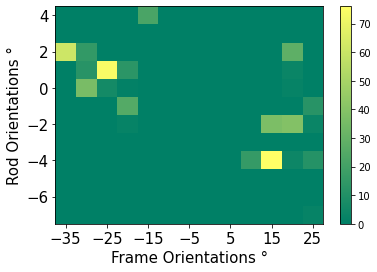

In [193]:
# Stimuli absolute frequencies

x_bins = np.linspace(-37.5,27.5,14)
y_bins= np.linspace(-7.5, 4.5, 13)
plt.hist2d(frames, rods, cmap='summer', bins=[x_bins, y_bins])
plt.xticks(np.linspace(-35, 25, 7))
plt.xlabel('Frame Orientations °', fontsize=15)
plt.ylabel('Rod Orientations °', fontsize=15)
plt.tick_params(labelsize=15)
plt.colorbar()
plt.savefig('plots/stimulus_selection_frequency.png', bbox_inches='tight')

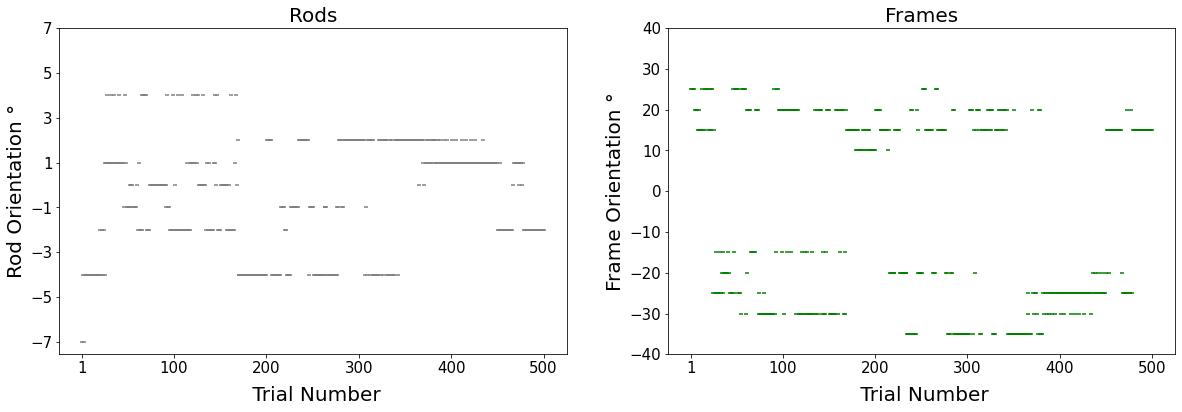

In [148]:
# Stimulus Selection

x = np.linspace(1,500,500)

fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].tick_params(labelsize=15)
ax[0].scatter(x, rods, s=10, marker='_', color='gray')
ax[0].set_xticks([1, 100, 200, 300, 400, 500])
ax[0].set_yticks([-7, -5, -3, -1, 1, 3, 5, 7])
ax[0].set_title('Rods', fontsize=20)
ax[0].set_ylabel('Rod Orientation °', fontsize=20)
ax[0].set_xlabel('\n Trial Number', fontsize=20, linespacing=0.1)


ax[1].tick_params(labelsize=15)
ax[1].scatter(x, frames, s=10, marker='_', color='green')
ax[1].set_xticks([1, 100, 200, 300, 400, 500])
ax[1].set_yticks(np.linspace(-40,40,9))
ax[1].set_title('Frames', fontsize=20)
ax[1].set_ylabel('Frame Orientation °', fontsize=20)
ax[1].set_xlabel('\n Trial Number', fontsize=20, linespacing=0.1)

fig.savefig(f'plots/stimulus_selection.png')

In [47]:
# Mean marginal distributions

marginal_lambda_means = np.zeros((n_trials, disc))
marginal_beta_means = np.zeros((n_trials, disc))
marginal_kv_means = np.zeros((n_trials, disc))
marginal_kh_means = np.zeros((n_trials, disc))
marginal_tau_means = np.zeros((n_trials, disc))
marginal_sigma_means = np.zeros((n_trials, disc))

for nr in tqdm(range(1,11)):
    
    priors =  np.load(f'Thesis/code/data/adaptive_stimulus_selection/output/disc_{disc}_priors_run_{nr}.npz')['arr_0']
    
    marginal_lambda = np.zeros((n_trials, disc))
    marginal_sigma = np.zeros((n_trials, disc))
    marginal_tau = np.zeros((n_trials, disc))
    marginal_kv = np.zeros((n_trials, disc))
    marginal_kh = np.zeros((n_trials, disc))
    marginal_beta = np.zeros((n_trials, disc))
    
    for t in range(n_trials):
    
        marginal_lambda[t:] = np.array([np.sum([priors[t][i + j * disc] for j in range(disc**5)]) for i in range(disc)])
        marginal_sigma[t:] = np.array([np.sum([priors[t][j * disc + i * disc**2 : (j+1) * disc + i * disc**2] for i in range(int((disc**6 - disc**2) / disc**2) + 1)]) for j in range(disc)])
        marginal_tau[t:] = np.array([np.sum([priors[t][j * disc**2 + i * disc**3 : (j+1) * disc**2 + i * disc**3] for i in range(int((disc**6 - disc**3) / disc**3) + 1)]) for j in range(disc)])
        marginal_kh[t:] = np.array([np.sum([priors[t][j * disc**3 + i * disc**4 : (j+1) * disc**3 + i * disc**4] for i in range(int((disc**6 - disc**4) / disc**4) + 1)]) for j in range(disc)])
        marginal_kv[t:] = np.array([np.sum([priors[t][j * disc**4 + i * disc**5 : (j+1) * disc**4 + i * disc**5] for i in range(int((disc**6 - disc**5) / disc**5) + 1)]) for j in range(disc)])
        marginal_beta[t:] = np.array([np.sum([priors[t][j * disc**5 : (j+1) * disc**5]]) for j in range(disc)])
    
    marginal_lambda_means += marginal_lambda / 10
    marginal_beta_means += marginal_beta / 10
    marginal_kv_means += marginal_kv / 10
    marginal_kh_means += marginal_kh / 10
    marginal_tau_means += marginal_tau / 10
    marginal_sigma_means += marginal_sigma / 10

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.76s/it]


In [48]:
# Variance around mean marginal probabilities

marginal_lambda_var = np.zeros((n_trials, disc))
marginal_beta_var = np.zeros((n_trials, disc))
marginal_kv_var = np.zeros((n_trials, disc))
marginal_kh_var = np.zeros((n_trials, disc))
marginal_tau_var = np.zeros((n_trials, disc))
marginal_sigma_var = np.zeros((n_trials, disc))

for nr in tqdm(range(1,11)):
    
    priors =  np.load(f'Thesis/code/data/adaptive_stimulus_selection/output/disc_{disc}_priors_run_{nr}.npz')['arr_0']
    
    marginal_lambda = np.zeros((n_trials, disc))
    marginal_sigma = np.zeros((n_trials, disc))
    marginal_tau = np.zeros((n_trials, disc))
    marginal_kv = np.zeros((n_trials, disc))
    marginal_kh = np.zeros((n_trials, disc))
    marginal_beta = np.zeros((n_trials, disc))
    
    for t in range(n_trials):
    
        marginal_lambda[t:] = np.array([np.sum([priors[t][i + j * disc] for j in range(disc**5)]) for i in range(disc)])
        marginal_sigma[t:] = np.array([np.sum([priors[t][j * disc + i * disc**2 : (j+1) * disc + i * disc**2] for i in range(int((disc**6 - disc**2) / disc**2) + 1)]) for j in range(disc)])
        marginal_tau[t:] = np.array([np.sum([priors[t][j * disc**2 + i * disc**3 : (j+1) * disc**2 + i * disc**3] for i in range(int((disc**6 - disc**3) / disc**3) + 1)]) for j in range(disc)])
        marginal_kh[t:] = np.array([np.sum([priors[t][j * disc**3 + i * disc**4 : (j+1) * disc**3 + i * disc**4] for i in range(int((disc**6 - disc**4) / disc**4) + 1)]) for j in range(disc)])
        marginal_kv[t:] = np.array([np.sum([priors[t][j * disc**4 + i * disc**5 : (j+1) * disc**4 + i * disc**5] for i in range(int((disc**6 - disc**5) / disc**5) + 1)]) for j in range(disc)])
        marginal_beta[t:] = np.array([np.sum([priors[t][j * disc**5 : (j+1) * disc**5]]) for j in range(disc)])
    
    marginal_lambda_var += (marginal_lambda_means - marginal_lambda)**2 / 10
    marginal_beta_var += (marginal_beta_means - marginal_beta)**2 / 10
    marginal_kv_var += (marginal_kv_means - marginal_kv)**2 / 10 
    marginal_kh_var += (marginal_kh_means - marginal_kh)**2 / 10
    marginal_tau_var += (marginal_tau_means - marginal_tau)**2 / 10
    marginal_sigma_var += (marginal_sigma_means - marginal_sigma)**2 / 10     

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.72s/it]


In [129]:
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

betas = np.linspace(0.0366, 0.1257, disc)
k_vs = np.linspace(50.6595, 133.6400, disc)
k_hs = np.linspace(0.5274, 9.9156, disc)
taus = np.linspace(0.79, 1, disc)
sigmas = np.linspace(0.0942, 0.2862, disc)
lambdas = np.linspace(0.001, 0.04, disc)


plt.errorbar(lambdas, marginal_lambda_means[-1], yerr=marginal_lambda_var[-1], fmt='.', color='grey', ecolor='black', elinewidth=0.5, capsize=2);
plt.vlines(true_params[0], 0, 0.3, color='lightgreen')
plt.ylim(ymin=0, ymax=0.3)
plt.xticks(lambdas)
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
plt.title(r'$\lambda$', fontsize=15)
plt.ylabel(r'$P(\lambda | D)$', fontsize=15)
plt.savefig(f'plots/lambda_marginal.png')
plt.close()

plt.errorbar(betas, marginal_beta_means[-1], yerr=marginal_beta_var[-1], fmt='.', color='grey', ecolor='black', elinewidth=0.5, capsize=2);
plt.vlines(true_params[1], -0.05, 1, color='lightgreen')
plt.ylim(ymin=-0.05, ymax=1)
plt.xticks(betas)
plt.title(r'$\beta_{H_s}$', fontsize=15)
plt.ylabel(r'$P(\beta_{H_s}| D)$', fontsize=15)
plt.savefig(f'plots/beta_marginal.png')
plt.close()

plt.errorbar(k_vs, marginal_kv_means[-1], yerr=marginal_kv_var[-1], fmt='.', color='grey', ecolor='black', elinewidth=0.5, capsize=2);
plt.vlines(true_params[2], 0, 1, color='lightgreen')
plt.ylim(ymin=0, ymax=0.4)
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5])
plt.xticks(k_vs)
plt.title(r'$\kappa_v$', fontsize=15)
plt.ylabel(r'$P(\kappa_v | D)$', fontsize=15)
plt.savefig(f'plots/kv_marginal.png')
plt.close()

plt.errorbar(k_hs, marginal_kh_means[-1], yerr=marginal_kh_var[-1], fmt='.', color='grey', ecolor='black', elinewidth=0.5, capsize=2);
plt.vlines(true_params[3], -0.05, 1, color='lightgreen')
plt.ylim(ymin=-0.01, ymax=0.45)
plt.xticks(k_hs)
plt.title(r'$\kappa_h$', fontsize=15)
plt.ylabel(r'$P(\kappa_h | D)$', fontsize=15)
plt.savefig(f'plots/kh_marginal.png')
plt.close()

plt.errorbar(taus, marginal_tau_means[-1], yerr=marginal_tau_var[-1], fmt='.', color='grey', ecolor='black', elinewidth=0.5, capsize=2);
plt.vlines(true_params[4], -0.05, 1, color='lightgreen')
plt.ylim(ymin=0, ymax=0.25)
plt.xticks(taus)
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25])
plt.title(r'$\tau$', fontsize=15)
plt.ylabel(r'$P(\tau | D)$', fontsize=15)
plt.savefig(f'plots/tau_marginal.png')
plt.close()

plt.errorbar(sigmas, marginal_sigma_means[-1], yerr=marginal_sigma_var[-1], fmt='.', color='grey', ecolor='black', elinewidth=0.5, capsize=2);
plt.vlines(true_params[5], -0.05, 1, color='lightgreen')
plt.ylim(ymin=0, ymax=0.25)
plt.xticks(sigmas)
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25])
plt.title(r'$\sigma_{H_p}$', fontsize=15)
plt.ylabel(r'$P(\sigma_{H_p} | D)$', fontsize=15)
plt.savefig(f'plots/sigma_marginal.png')
plt.close()